# DataRes Consulting Fall 2022

Project: Assisting a compnay called HomeDescription where we are going to use NLP to determine what factors are the most important in selling a house.  
Mostly going to look at factors such as the description (words), location, selling price, zestimate, & agencies

This notebook is for NLP WORK

In [2]:
# Import all of the important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import linregress
from matplotlib.ticker import PercentFormatter

In [3]:
data = pd.read_excel("ZILLOW_DATA_CA_22-02-2022.xlsx")
data.columns = data.iloc[0, :]
data.drop(data.index[0], inplace = True)

data_new = pd.read_csv("zillow_added_variables.csv")
take_out_outliers = data_new[data_new["pricedif"] < 100000000]

C:\Users\derek\AppData\Local\Temp\ipykernel_26272\4149247165.py:5: DtypeWarning: Columns (12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_new = pd.read_csv("zillow_added_variables.csv")


In [4]:
(take_out_outliers[["days_on_zillow"]]).describe()
(take_out_outliers[["num_words"]]).describe()
(take_out_outliers[["pricedif"]]).describe()

,pricedif
count,2.483600e+04
mean,-1.346349e+05
std,6.269084e+05
min,-1.643630e+07
25%,-1.410000e+05
50%,-7.450000e+04
75%,-3.800000e+04
max,1.659220e+07


In [5]:
# New Variable Percent Above Zillow
take_out_outliers["percent_above_zillow"] = take_out_outliers.apply(lambda row: (row.price - row.zestimate) / row.zestimate, axis = 1)
percent_data = take_out_outliers[(take_out_outliers["percent_above_zillow"] > -1.165) & (take_out_outliers["percent_above_zillow"] < 0.999)]
(percent_data[["percent_above_zillow"]]).describe()

C:\Users\derek\AppData\Local\Temp\ipykernel_26272\3833522305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_out_outliers["percent_above_zillow"] = take_out_outliers.apply(lambda row: (row.price - row.zestimate) / row.zestimate, axis = 1)


,percent_above_zillow
count,24737.000000
mean,-0.098983
std,0.145192
min,-0.999921
25%,-0.112971
50%,-0.080144
75%,-0.043943
max,0.994813


Ideas: 
* classify between slow, medium, and fast and see which are the most popular terms
* Keyword/topic Extraction
* LDA <-- more or less my task
lower all of the terms, lemitize them <-- dictionary 

Isolate ones with different Zestimate/Actual selling price
* clustering
* what factors are important in selecting a house
* how to train machine learning algorhytm: bad/good desciption

# Creating New Vars

In [6]:
new_precent_data = percent_data[percent_data["property_type"] == "SINGLE_FAMILY"]
new_precent_data = new_precent_data[["days_on_zillow","zipcode", "zestimate", "price", "pricedif", "description", "num_words", "num_chars", "percent_above_zillow"]]

speed_condition = [
    (new_precent_data["days_on_zillow"] <= 106),
    (new_precent_data["days_on_zillow"] > 106) & (new_precent_data["days_on_zillow"] < 279),
    (new_precent_data["days_on_zillow"] >= 279)
]
speed_values = ["fast", "medium", "slow"]


percent_condition = [
    (new_precent_data["percent_above_zillow"] >= -0.043943),
    (new_precent_data["percent_above_zillow"] < -0.043943) & (new_precent_data["percent_above_zillow"] > -0.112971),
    (new_precent_data["percent_above_zillow"] <= -0.112971)
]
percent_values = ["higher", "normal", "lower"] 

data_for_nlp = new_precent_data
data_for_nlp["selling_speed"] = np.select(speed_condition, speed_values)
data_for_nlp["selling_percent"] = np.select(percent_condition, percent_values)



data_for_nlp["categories"] = data_for_nlp.apply(lambda row: "sold_" + str(row.selling_speed) + "_" + str(row.selling_percent) + "_cost", axis = 1)
description_condition = [
    (data_for_nlp["categories"] == "sold_fast_normal_cost") | (data_for_nlp["categories"] == "sold_fast_higher_cost") | (data_for_nlp["categories"] == "sold_medium_higher_cost"),
    (data_for_nlp["categories"] == "sold_slow_higher_cost") | (data_for_nlp["categories"] == "sold_medium_normal_cost") | (data_for_nlp["categories"] == "sold_fast_lower_cost"),
    (data_for_nlp["categories"] == "sold_slow_lower_cost") | (data_for_nlp["categories"] == "sold_slow_normal_cost") | (data_for_nlp["categories"] == "sold_medium_lower_cost")
]
desciription_rating = ["good", "normal", "bad"] 

data_for_nlp["description_rating"] = np.select(description_condition, desciription_rating)

In [7]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
import os
import ast
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import spacy
import textstat

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\derek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
data_for_nlp["reading_ease"] = data_for_nlp.description.progress_apply(lambda x: textstat.flesch_reading_ease(x))
data_for_nlp["grade_level"] = data_for_nlp.description.progress_apply(lambda x: textstat.text_standard(x, float_output = True))
data_for_nlp["reading_time"] = data_for_nlp.description.progress_apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))
data_for_nlp["sentence_count"] = data_for_nlp.description.progress_apply(lambda x: textstat.sentence_count(x))

100%|██████████| 16395/16395 [00:01<00:00, 13560.87it/s]


In [9]:
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import RegexpTokenizer

def text_clean(string):
    words = []
    tokenizer = RegexpTokenizer((r'\w+')) # load function that tokenizes into words and keeps only alphanumeric characters 
    text = tokenizer.tokenize(string.lower()) # tokenize the input and lower every word
    text = nlp(" ".join(text)) 
    for token in text:
        # remove stopwords and lemmatize rest 
        if token.is_stop == False:
            words += [token.lemma_]
    return (" ").join(words)

data_for_nlp["clean_description"] = data_for_nlp.description.progress_apply(text_clean)

100%|██████████| 16395/16395 [06:50<00:00, 39.98it/s]


In [12]:
import fasttext
model = fasttext.train_unsupervised("cleaned_text_corpus.txt")

data_for_nlp["vec"] = data_for_nlp.clean_description.progress_apply(lambda x: model.get_sentence_vector(x))

100%|██████████| 16395/16395 [00:08<00:00, 1928.00it/s]


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
data_for_nlp['x'] = pca.fit_transform(data_for_nlp["vec"].values.tolist())[:,0]
data_for_nlp['y'] = pca.fit_transform(data_for_nlp["vec"].values.tolist())[:,1]
data_for_nlp['z'] = pca.fit_transform(data_for_nlp["vec"].values.tolist())[:,2]

In [22]:
data_for_nlp.head()

,days_on_zillow,zipcode,zestimate,price,pricedif,description,num_words,num_chars,percent_above_zillow,selling_speed,...,description_rating,reading_ease,grade_level,reading_time,sentence_count,clean_description,vec,x,y,z
1,4.0,91342,623000.0,688000,65000.0,SOLD BEFORE PROCESSING - Welcome home to this ...,70.0,386.0,0.104334,fast,...,good,70.84,8.0,4.61,4,sell process welcome home lovely 3 bedroom 2 b...,"[-0.029423393, -0.0050766137, -0.13607374, -0....",0.001826,-0.062373,-0.004958
3,5.0,91335,692800.0,700000,7200.0,3 Bedroom 2 bath home in the desirable area of...,44.0,265.0,0.010393,fast,...,good,57.61,11.0,3.22,2,3 bedroom 2 bath home desirable area reseda co...,"[-0.012284192, -0.0057158615, -0.19094291, -0....",-0.023971,0.003277,-0.096059
4,5.0,91402,660900.0,690000,29100.0,Single family home first time back on the mark...,65.0,399.0,0.044031,fast,...,good,71.85,11.0,4.91,4,single family home time market 1975 great oppo...,"[-0.029433241, -0.023700915, -0.15056905, -0.0...",0.077091,0.024962,-0.073977
6,6.0,91402,714300.0,705000,-9300.0,Looking for a move in ready single story home ...,184.0,1020.0,-0.013020,fast,...,good,82.44,8.0,12.28,13,look ready single story home pool entertain fa...,"[-0.018933384, 0.0021600733, -0.14362459, -0.0...",-0.058050,0.046527,-0.076394
9,7.0,91331,736900.0,689500,-47400.0,IN ESCROW,2.0,9.0,-0.064324,fast,...,good,77.91,0.0,0.12,1,escrow,"[0.0992623, 0.038816307, -0.099248454, 0.16937...",0.230986,0.534342,0.114731


# Finding Correlations

In [12]:
# Sample of 1800
samples = data_for_nlp.groupby("categories").sample(200, replace=True)
samples = data_for_nlp[["num_words", "percent_above_zillow", "reading_ease", "grade_level", "reading_time"]]

<AxesSubplot:xlabel='grade_level', ylabel='categories'>

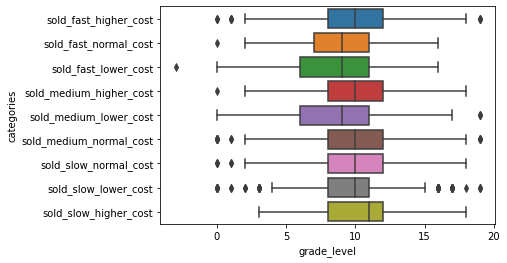

In [25]:
data_for_nlp_grade = data_for_nlp[data_for_nlp["grade_level"] < 20]
grade_level = data_for_nlp_grade.groupby(["categories"])[["grade_level"]]

sns.boxplot(y = data_for_nlp_grade["categories"], x = data_for_nlp_grade["grade_level"])

# Clustering - This Data is not Balanced

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


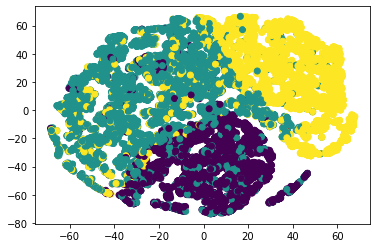

In [26]:
cluster = data_for_nlp[["num_words", "reading_ease", "grade_level", "sentence_count"]]
cluster2 = data_for_nlp[["days_on_zillow", "days_on_zillow", "num_words", "reading_ease", "grade_level", "sentence_count"]]
#data_labels = data_for_nlp["description_rating"]
#percent_above_zillow & days_on_zillow

#from sklearn.cluster import KMeans
#model_kmeans = KMeans(n_clusters = 3) 
#model_kmeans.fit(cluster)
#labels = model_kmeans.predict(cluster) 


new_labels = [
    (data_for_nlp["description_rating"] == "good"),
    (data_for_nlp["description_rating"] == "normal"),
    (data_for_nlp["description_rating"] == "bad")
]
des_labels = [0,1,2] 
data_labels = np.select(new_labels, des_labels)

from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 100) 
transformed = model_tsne.fit_transform(cluster2)
plt.scatter(transformed[:,0], transformed[:,1], c=data_labels)

accuracy at k = 1 is 0.35986581274778895
accuracy at k = 2 is 0.3446172613601708
accuracy at k = 3 is 0.35986581274778895
accuracy at k = 4 is 0.36596523330283626
accuracy at k = 5 is 0.3671851174138457
accuracy at k = 6 is 0.38334858188472093
accuracy at k = 7 is 0.37572430619091185
accuracy at k = 8 is 0.3854833790789875
accuracy at k = 9 is 0.3955474229948155
accuracy at k = 10 is 0.3897529734675206
accuracy at k = 11 is 0.38365355291247333
accuracy at k = 12 is 0.39493748093931075
accuracy at k = 13 is 0.39615736505032023
accuracy at k = 14 is 0.39859713327233914
accuracy at k = 15 is 0.4025617566331198
accuracy at k = 16 is 0.3903629155230253
accuracy at k = 17 is 0.39585239402256783
accuracy at k = 18 is 0.40500152485513874
accuracy at k = 19 is 0.40164684354986274
accuracy at k = 20 is 0.4028667276608722
accuracy at k = 21 is 0.396767307105825
accuracy at k = 22 is 0.3955474229948155
accuracy at k = 23 is 0.40164684354986274
accuracy at k = 24 is 0.40317169868862457
accuracy at 

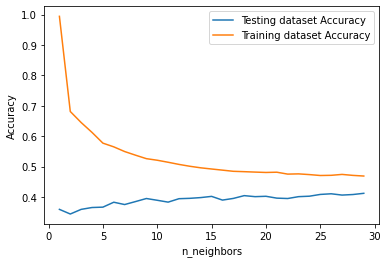

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

x_vars = data_for_nlp[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]
y_vars = data_for_nlp["description_rating"]
X_train, X_test, y_train, y_test = train_test_split( x_vars, y_vars, test_size = 0.20, random_state = 53)

neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
      
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    pred_y = knn.predict(X_test)
    print("accuracy at k = " + str(k) + " is " + str(metrics.accuracy_score(y_test, pred_y)))
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

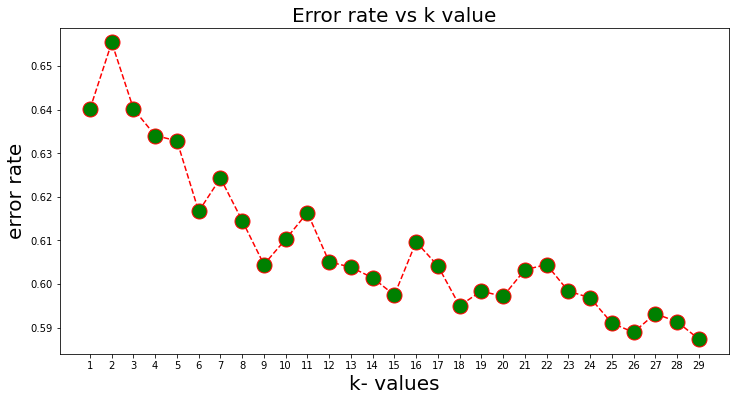

In [37]:
x_vars = data_for_nlp[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]
y_vars = data_for_nlp["description_rating"]
X_train, X_test, y_train, y_test = train_test_split( x_vars, y_vars, test_size = 0.20, random_state = 53)


error_rate=[] #list that will store the average error rate value of k
for i in range (1,30):  
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    pred_i = clf.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12,6))
plt.plot(range(1,30),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,30))
plt.show()

# Taking a Sample and performing clustering

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


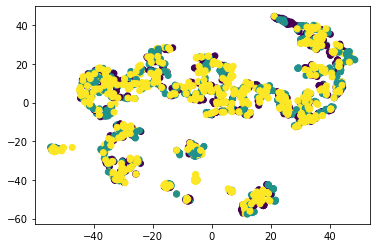

In [41]:
samples = data_for_nlp.groupby("categories").sample(200, replace=True)
cluster_sample = samples[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]

new_labels = [
    (samples["description_rating"] == "good"),
    (samples["description_rating"] == "normal"),
    (samples["description_rating"] == "bad")
]
des_labels = [0,1,2] 
data_labels = np.select(new_labels, des_labels)

from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 100) 
transformed = model_tsne.fit_transform(cluster_sample)
plt.scatter(transformed[:,0], transformed[:,1], c=data_labels)
plt.show()

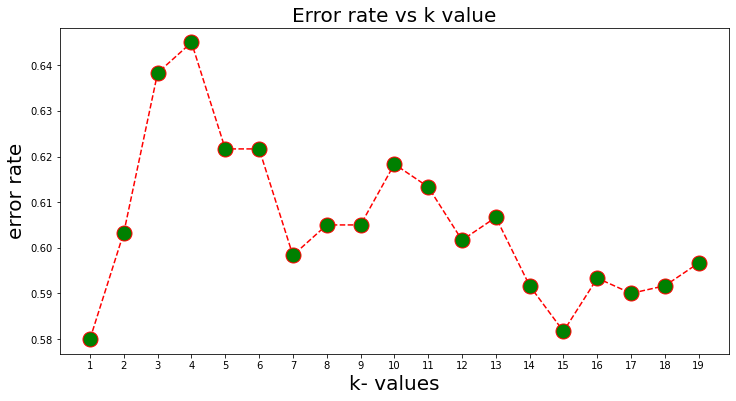

In [45]:
samples = data_for_nlp.groupby("description_rating").sample(1000, replace=True)
x_vars = samples[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]
y_vars = samples["description_rating"]
X_train, X_test, y_train, y_test = train_test_split( x_vars, y_vars, test_size = 0.20, random_state = 53)


error_rate=[] #list that will store the average error rate value of k
for i in range (1,20):  
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    pred_i = clf.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12,6))
plt.plot(range(1,20),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,20))
plt.show()

# Per Zipcode

In [46]:
data_for_nlp.groupby("description_rating")["categories"].count()
count = data_for_nlp.groupby(["zipcode"])["clean_description"].count().reset_index()
hello = count[count["clean_description"] > 100]
zipcodes_imp = hello["zipcode"].head(5)

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


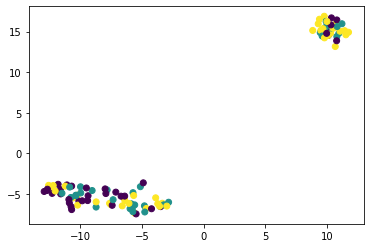

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


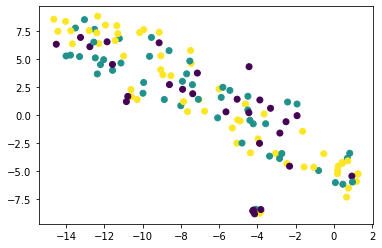

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


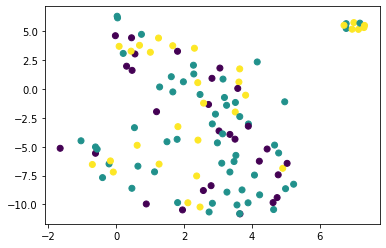

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


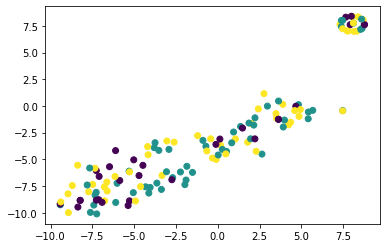

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


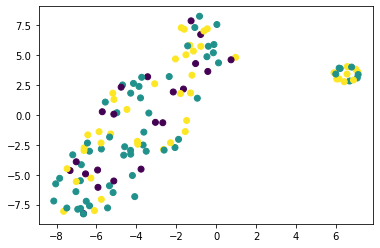

In [48]:
for i in zipcodes_imp: 
    zip_code = data_for_nlp[(data_for_nlp["zipcode"] == i)]
    data4 = zip_code[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]
    data5 = zip_code[["days_on_zillow", "percent_above_zillow", "num_words", "reading_ease", "grade_level", "sentence_count"]]
    new_labels = [ 
        (zip_code["description_rating"] == "good"),
        (zip_code["description_rating"] == "normal"),
        (zip_code["description_rating"] == "bad")
    ]
    des_labels = [0,1,2] 
    data_labels = np.select(new_labels, des_labels)


    from sklearn.manifold import TSNE
    model_tsne = TSNE(learning_rate = 100) 
    transformed = model_tsne.fit_transform(data4)
    plt.scatter(transformed[:,0], transformed[:,1], c=data_labels)
    plt.show()

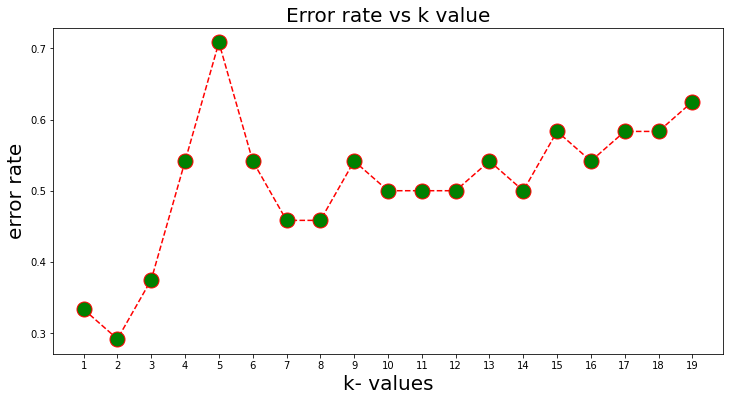

In [49]:
samples = zip_code.groupby("description_rating").sample(40, replace=True)
x_vars = samples[["num_words", "reading_ease", "grade_level", "sentence_count"]]
y_vars = samples["description_rating"]
X_train, X_test, y_train, y_test = train_test_split( x_vars, y_vars, test_size = 0.20, random_state = 53)

error_rate=[] #list that will store the average error rate value of k
for i in range (1,20):  
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    pred_i = clf.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12,6))
plt.plot(range(1,20),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,20))
plt.show()

# Per Price Amount

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


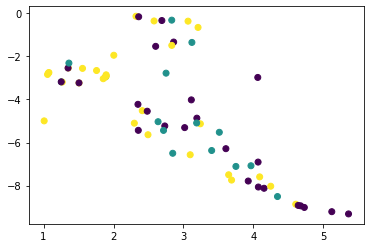

In [60]:
zip_code = data_for_nlp[(data_for_nlp["zestimate"] >= 500000) & (data_for_nlp["zestimate"] <= 700000) & (data_for_nlp["zipcode"] == 90003)]
data4 = zip_code[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]
data5 = zip_code[["days_on_zillow", "percent_above_zillow", "num_words", "reading_ease", "grade_level", "sentence_count"]]
new_labels = [ 
    (zip_code["description_rating"] == "good"),
    (zip_code["description_rating"] == "normal"),
    (zip_code["description_rating"] == "bad")
]
des_labels = [0,1,2] 
data_labels = np.select(new_labels, des_labels)


from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 100) 
transformed = model_tsne.fit_transform(data4)
plt.scatter(transformed[:,0], transformed[:,1], c=data_labels)
plt.show()

# Balancing Data

In [52]:
other.groupby("description_rating")["num_words"].count()

description_rating
bad       5201
good      4145
normal    7049
Name: num_words, dtype: int64

In [50]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# define dataset
other = data_for_nlp
mess = other[(other["description_rating"] == "good") | (other["description_rating"] == "normal")]
mess2 = mess[["num_words", "reading_ease", "grade_level", "sentence_count", "x", "y", "z"]]

from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 100) 
transformed = model_tsne.fit_transform(mess2)
X = transformed
y = mess["description_rating"]

C:\Users\derek\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Counter({'normal': 7049, 'good': 4145})
Counter({'good': 7049, 'normal': 7049})


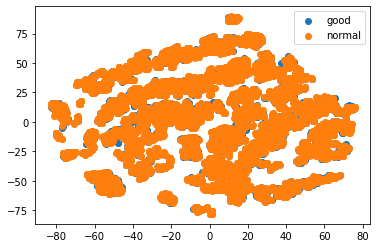

In [51]:
# summarize class distribution
counter = Counter(y)
print(counter)

# transform the dataset
oversample = SMOTE()
new_x, new_y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(new_y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# Other

In [18]:
data_for_nlp.to_csv("data_with_categories.csv", index = False)

In [246]:
data_for_nlp.head()

,days_on_zillow,zipcode,zestimate,price,pricedif,description,num_words,num_chars,percent_above_zillow,selling_speed,selling_percent,categories,description_rating,reading_ease,grade_level,reading_time,sentence_count,clean_description
1,4.0,91342,623000.0,688000,65000.0,SOLD BEFORE PROCESSING - Welcome home to this ...,70.0,386.0,0.104334,fast,higher,sold_fast_higher_cost,good,70.84,8.0,4.61,4,sell process welcome home lovely 3 bedroom 2 b...
3,5.0,91335,692800.0,700000,7200.0,3 Bedroom 2 bath home in the desirable area of...,44.0,265.0,0.010393,fast,higher,sold_fast_higher_cost,good,57.61,11.0,3.22,2,3 bedroom 2 bath home desirable area reseda co...
4,5.0,91402,660900.0,690000,29100.0,Single family home first time back on the mark...,65.0,399.0,0.044031,fast,higher,sold_fast_higher_cost,good,71.85,11.0,4.91,4,single family home time market 1975 great oppo...
6,6.0,91402,714300.0,705000,-9300.0,Looking for a move in ready single story home ...,184.0,1020.0,-0.013020,fast,higher,sold_fast_higher_cost,good,82.44,8.0,12.28,13,look ready single story home pool entertain fa...
9,7.0,91331,736900.0,689500,-47400.0,IN ESCROW,2.0,9.0,-0.064324,fast,normal,sold_fast_normal_cost,good,77.91,0.0,0.12,1,escrow


In [61]:
data_for_nlp

,days_on_zillow,zipcode,zestimate,price,pricedif,description,num_words,num_chars,percent_above_zillow,selling_speed,...,description_rating,reading_ease,grade_level,reading_time,sentence_count,clean_description,vec,x,y,z
1,4.0,91342,623000.0,688000,65000.0,SOLD BEFORE PROCESSING - Welcome home to this ...,70.0,386.0,0.104334,fast,...,good,70.84,8.0,4.61,4,sell process welcome home lovely 3 bedroom 2 b...,"[-0.029423393, -0.0050766137, -0.13607374, -0....",0.001826,-0.062373,-0.004958
3,5.0,91335,692800.0,700000,7200.0,3 Bedroom 2 bath home in the desirable area of...,44.0,265.0,0.010393,fast,...,good,57.61,11.0,3.22,2,3 bedroom 2 bath home desirable area reseda co...,"[-0.012284192, -0.0057158615, -0.19094291, -0....",-0.023971,0.003277,-0.096059
4,5.0,91402,660900.0,690000,29100.0,Single family home first time back on the mark...,65.0,399.0,0.044031,fast,...,good,71.85,11.0,4.91,4,single family home time market 1975 great oppo...,"[-0.029433241, -0.023700915, -0.15056905, -0.0...",0.077091,0.024962,-0.073977
6,6.0,91402,714300.0,705000,-9300.0,Looking for a move in ready single story home ...,184.0,1020.0,-0.013020,fast,...,good,82.44,8.0,12.28,13,look ready single story home pool entertain fa...,"[-0.018933384, 0.0021600733, -0.14362459, -0.0...",-0.058050,0.046527,-0.076394
9,7.0,91331,736900.0,689500,-47400.0,IN ESCROW,2.0,9.0,-0.064324,fast,...,good,77.91,0.0,0.12,1,escrow,"[0.0992623, 0.038816307, -0.099248454, 0.16937...",0.230986,0.534342,0.114731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27060,362.0,90032,931200.0,803000,-128200.0,Nestled in the quiet neighborhood of El Serren...,225.0,1500.0,-0.137672,slow,...,bad,43.06,15.0,18.73,8,nestle quiet neighborhood el serreno beautiful...,"[-0.038186576, 0.012916622, -0.113935806, -0.0...",-0.106428,-0.025365,0.000321
27061,362.0,90065,927700.0,800000,-127700.0,"This Spanish inspired bungalow, primely situat...",103.0,704.0,-0.137652,slow,...,bad,48.09,13.0,8.84,7,spanish inspire bungalow primely situate mount...,"[-0.051734466, 0.027226357, -0.12255757, -0.00...",-0.124396,0.064910,0.041440
27062,362.0,91307,1215000.0,810000,-405000.0,This one is what you were waiting for. You ca...,174.0,1012.0,-0.333333,slow,...,bad,73.88,9.0,12.30,12,wait home market say feel pride ownership soon...,"[0.00366873, 0.009411206, -0.12249067, -0.0338...",-0.086849,-0.033725,-0.015098
27064,365.0,90732,940600.0,810000,-130600.0,This San Pedro one-story cul-de-sac home offer...,10.0,65.0,-0.138848,slow,...,bad,69.79,6.0,0.82,1,san pedro story cul de sac home offer car garage,"[0.0084342, -0.009512329, -0.12318231, 0.03140...",0.090213,0.120112,-0.112510


In [57]:
zipcodes_imp

2     90003
3     90004
7     90008
12    90016
14    90018
Name: zipcode, dtype: int64

In [63]:
#plt.scatter(data_for_nlp["days_on_zillow"], data_for_nlp["percent_above_zillow"])